In [48]:
!nvidia-smi

Fri Sep 22 11:22:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    58W / 400W |   1011MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
import itertools
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler

## Check GPU

In [50]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda")
else:
    device = torch.device("cpu")
    print("cpu")

cuda


## Train ,test dataset

In [51]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


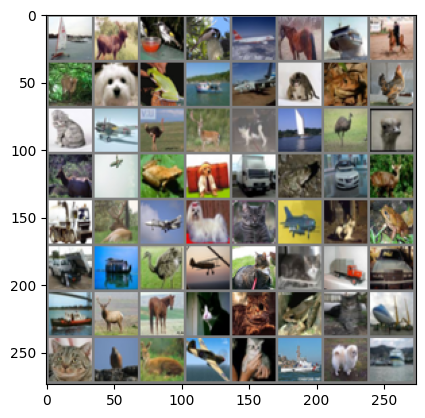

ship  deer  bird  bird  plane horse ship  horse deer  dog   frog  ship  plane cat   frog  bird  cat   plane bird  deer  dog   ship  bird  bird  deer  plane frog  dog   truck frog  car   deer  truck deer  plane dog   cat   plane cat   frog  truck ship  bird  plane cat   cat   truck car   ship  deer  horse cat   cat   frog  cat   plane cat   bird  deer  plane cat   ship  dog   ship 


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Create Neural Network MLP

In [53]:
import torch.nn as nn
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(32 * 32 * 3, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 128)
#         self.fc4 = nn.Linear(128, 64)
#         self.fc5 = nn.Linear(64, 64)
#         self.fc6 = nn.Linear(64, 64)
#         self.fc7 = nn.Linear(64, 64)
#         self.fc8 = nn.Linear(64, 64)
#         self.fc9 = nn.Linear(64, 64)
#         self.fc10 = nn.Linear(64, 10)

#     def forward(self, x):
#         x = x.view(-1, 32 * 32 * 3)
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         x = torch.relu(self.fc5(x))
#         x = torch.relu(self.fc6(x))
#         x = torch.relu(self.fc7(x))
#         x = torch.relu(self.fc8(x))
#         x = torch.relu(self.fc9(x))
#         x = self.fc10(x)
#         return x

import torch.nn as nn
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(32 * 32 * 3, 512)
#         self.bn1 = nn.BatchNorm1d(512)
#         self.fc2 = nn.Linear(512, 256)
#         self.bn2 = nn.BatchNorm1d(256)
#         self.fc3 = nn.Linear(256, 128)
#         self.bn3 = nn.BatchNorm1d(128)
#         self.fc4 = nn.Linear(128, 64)
#         self.bn4 = nn.BatchNorm1d(64)
#         self.fc5 = nn.Linear(64, 64)
#         self.bn5 = nn.BatchNorm1d(64)
#         self.fc6 = nn.Linear(64, 64)
#         self.bn6 = nn.BatchNorm1d(64)
#         self.fc7 = nn.Linear(64, 64)
#         self.bn7 = nn.BatchNorm1d(64)
#         self.fc8 = nn.Linear(64, 64)
#         self.bn8 = nn.BatchNorm1d(64)
#         self.fc9 = nn.Linear(64, 64)
#         self.bn9 = nn.BatchNorm1d(64)
#         self.fc10 = nn.Linear(64, 10)
#         self.dropout = nn.Dropout(0.5)  # Dropout layer

#     def forward(self, x):
#         x = x.view(-1, 32 * 32 * 3)
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = F.relu(self.bn2(self.fc2(x)))
#         x = F.relu(self.bn3(self.fc3(x)))
#         x = F.relu(self.bn4(self.fc4(x)))
#         x = F.relu(self.bn5(self.fc5(x)))
#         x = F.relu(self.bn6(self.fc6(x)))
#         x = F.relu(self.bn7(self.fc7(x)))
#         x = F.relu(self.bn8(self.fc8(x)))
#         x = F.relu(self.bn9(self.fc9(x)))
#         x = self.fc10(x)
#         return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 10)  # Reduced to 5 layers

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)  # Output layer
        return x

In [54]:
net = Net()

net.to(device)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)

## Optimizer

In [55]:
criterion = nn.CrossEntropyLoss()

In [56]:
adam_optimizer = optim.Adam(net.parameters(), lr=0.001)
rmsprop_optimizer = optim.RMSprop(net.parameters(), lr=0.001)
sgd_optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [57]:
adam_scheduler = lr_scheduler.StepLR(adam_optimizer, step_size=10, gamma=0.1)
rmsprop_scheduler = lr_scheduler.StepLR(rmsprop_optimizer, step_size=10, gamma=0.1)
sgd_scheduler = lr_scheduler.StepLR(sgd_optimizer, step_size=10, gamma=0.1)

In [58]:
Net._dropout = nn.Dropout(p=0.5)

In [59]:
adam_train_loss_values = []
adam_train_accuracy_values = []
adam_test_loss_values = []
adam_test_accuracy_values = []

rmsprop_train_loss_values = []
rmsprop_train_accuracy_values = []
rmsprop_test_loss_values = []
rmsprop_test_accuracy_values = []

sgd_train_loss_values = []
sgd_train_accuracy_values = []
sgd_test_loss_values = []
sgd_test_accuracy_values = []

## Train Function

In [60]:
def train_and_plot(optimizer, name, train_loss_values, train_accuracy_values, test_loss_values, test_accuracy_values):
    for epoch in range(20):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # print(f'[{name}, Epoch {epoch + 1}] Training Loss: {running_loss / (i + 1):.4f} Accuracy: {train_accuracy:.2f}%'+f'[{name}, Epoch {epoch + 1}] Testing Loss: {test_loss / len(testloader):.4f} Accuracy: {test_accuracy:.2f}%')

        net.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # Calculate testing accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test

        # print(f'[{name}, Epoch {epoch + 1}] Testing Loss: {test_loss / len(testloader):.4f} Accuracy: {test_accuracy:.2f}%')
        print(f'[{name}, Epoch {epoch + 1}] Training Loss: {running_loss / (i + 1):.4f} Accuracy: {train_accuracy:.2f}%'+" ; "+f'[{name}, Epoch {epoch + 1}] Testing Loss: {test_loss / len(testloader):.4f} Accuracy: {test_accuracy:.2f}%')


        adam_scheduler.step()
        rmsprop_scheduler.step()
        sgd_scheduler.step()

        train_loss_values.append(running_loss / (i + 1))
        train_accuracy_values.append(train_accuracy)
        test_loss_values.append(test_loss / len(testloader))
        test_accuracy_values.append(test_accuracy)

        net.train()

In [61]:
adam_path = './cifar_net_adam.pth'
rmsprop_path = './cifar_net_rmsprop.pth'
sgd_path = './cifar_net_sgd.pth'

## Adam training

In [62]:
train_and_plot(adam_optimizer, "Adam", adam_train_loss_values, adam_train_accuracy_values, adam_test_loss_values, adam_test_accuracy_values)
torch.save(net.state_dict(), adam_path)

[Adam, Epoch 1] Training Loss: 1.6536 Accuracy: 40.95% ; [Adam, Epoch 1] Testing Loss: 1.4670 Accuracy: 48.02%


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[Adam, Epoch 2] Training Loss: 1.4289 Accuracy: 48.75% ; [Adam, Epoch 2] Testing Loss: 1.3692 Accuracy: 51.26%
[Adam, Epoch 3] Training Loss: 1.3180 Accuracy: 53.25% ; [Adam, Epoch 3] Testing Loss: 1.3088 Accuracy: 53.74%
[Adam, Epoch 4] Training Loss: 1.2402 Accuracy: 55.87% ; [Adam, Epoch 4] Testing Loss: 1.3081 Accuracy: 53.67%
[Adam, Epoch 5] Training Loss: 1.1632 Accuracy: 58.53% ; [Adam, Epoch 5] Testing Loss: 1.2803 Accuracy: 54.69%
[Adam, Epoch 6] Training Loss: 1.1049 Accuracy: 60.70% ; [Adam, Epoch 6] Testing Loss: 1.2658 Accuracy: 54.91%
[Adam, Epoch 7] Training Loss: 1.0353 Accuracy: 63.36% ; [Adam, Epoch 7] Testing Loss: 1.2912 Accuracy: 55.32%
[Adam, Epoch 8] Training Loss: 0.9829 Accuracy: 65.09% ; [Adam, Epoch 8] Testing Loss: 1.2526 Accuracy: 55.79%
[Adam, Epoch 9] Training Loss: 0.9231 Accuracy: 67.40% ; [Adam, Epoch 9] Testing Loss: 1.2859 Accuracy: 55.26%
[Adam, Epoch 10] Training Loss: 0.8677 Accuracy: 69.25% ; [Adam, Epoch 10] Testing Loss: 1.3079 Accuracy: 55.74%

## RMSprop training

In [63]:
train_and_plot(rmsprop_optimizer, "RMSprop", rmsprop_train_loss_values, rmsprop_train_accuracy_values, rmsprop_test_loss_values, rmsprop_test_accuracy_values)
torch.save(net.state_dict(), rmsprop_path)

[RMSprop, Epoch 1] Training Loss: 0.3860 Accuracy: 86.88% ; [RMSprop, Epoch 1] Testing Loss: 1.5223 Accuracy: 57.06%
[RMSprop, Epoch 2] Training Loss: 0.3845 Accuracy: 86.90% ; [RMSprop, Epoch 2] Testing Loss: 1.5111 Accuracy: 57.25%
[RMSprop, Epoch 3] Training Loss: 0.3784 Accuracy: 87.19% ; [RMSprop, Epoch 3] Testing Loss: 1.5223 Accuracy: 57.02%
[RMSprop, Epoch 4] Training Loss: 0.3753 Accuracy: 87.35% ; [RMSprop, Epoch 4] Testing Loss: 1.5336 Accuracy: 57.11%
[RMSprop, Epoch 5] Training Loss: 0.3755 Accuracy: 87.24% ; [RMSprop, Epoch 5] Testing Loss: 1.5245 Accuracy: 57.19%
[RMSprop, Epoch 6] Training Loss: 0.3745 Accuracy: 87.36% ; [RMSprop, Epoch 6] Testing Loss: 1.5219 Accuracy: 57.09%
[RMSprop, Epoch 7] Training Loss: 0.3718 Accuracy: 87.36% ; [RMSprop, Epoch 7] Testing Loss: 1.5223 Accuracy: 57.09%
[RMSprop, Epoch 8] Training Loss: 0.3651 Accuracy: 87.57% ; [RMSprop, Epoch 8] Testing Loss: 1.5393 Accuracy: 57.19%
[RMSprop, Epoch 9] Training Loss: 0.3632 Accuracy: 87.74% ; [RMS

## SGD training

In [64]:
train_and_plot(sgd_optimizer, "SGD", sgd_train_loss_values, sgd_train_accuracy_values, sgd_test_loss_values, sgd_test_accuracy_values)
torch.save(net.state_dict(), sgd_path)

[SGD, Epoch 1] Training Loss: 0.3552 Accuracy: 87.87% ; [SGD, Epoch 1] Testing Loss: 1.5425 Accuracy: 56.75%
[SGD, Epoch 2] Training Loss: 0.3584 Accuracy: 87.84% ; [SGD, Epoch 2] Testing Loss: 1.5593 Accuracy: 56.85%
[SGD, Epoch 3] Training Loss: 0.3551 Accuracy: 88.05% ; [SGD, Epoch 3] Testing Loss: 1.5429 Accuracy: 56.97%
[SGD, Epoch 4] Training Loss: 0.3564 Accuracy: 88.07% ; [SGD, Epoch 4] Testing Loss: 1.5690 Accuracy: 56.80%
[SGD, Epoch 5] Training Loss: 0.3579 Accuracy: 87.96% ; [SGD, Epoch 5] Testing Loss: 1.5612 Accuracy: 56.88%
[SGD, Epoch 6] Training Loss: 0.3557 Accuracy: 87.99% ; [SGD, Epoch 6] Testing Loss: 1.5630 Accuracy: 57.02%
[SGD, Epoch 7] Training Loss: 0.3574 Accuracy: 87.78% ; [SGD, Epoch 7] Testing Loss: 1.5498 Accuracy: 56.82%
[SGD, Epoch 8] Training Loss: 0.3570 Accuracy: 87.97% ; [SGD, Epoch 8] Testing Loss: 1.5532 Accuracy: 56.91%
[SGD, Epoch 9] Training Loss: 0.3540 Accuracy: 88.18% ; [SGD, Epoch 9] Testing Loss: 1.5445 Accuracy: 57.00%
[SGD, Epoch 10] Tra

## Compaire Adam, RMSprop and SGD via Loss and Accuracy

## Adam optimizer Loss and Accuracy

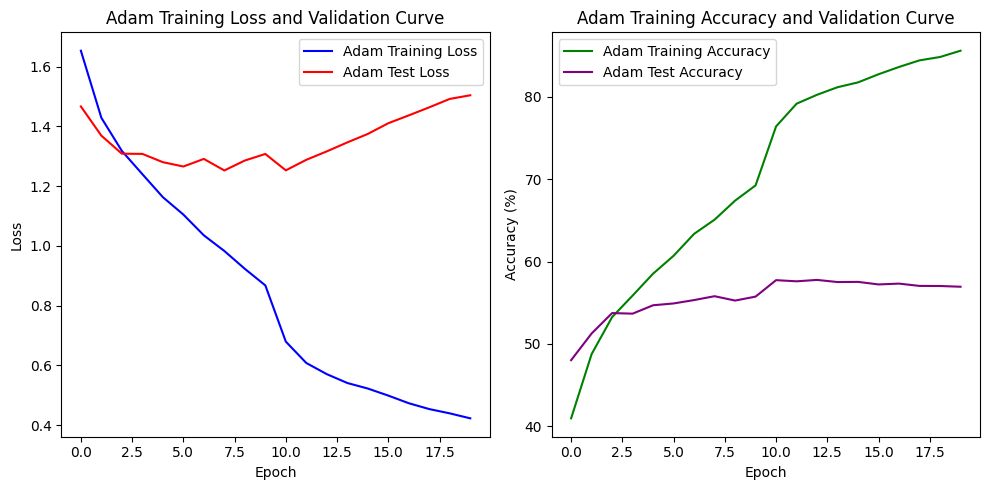

In [65]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(adam_train_loss_values, label='Adam Training Loss', color='blue')
plt.plot(adam_test_loss_values, label='Adam Test Loss', color='red')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Adam Training Loss and Validation Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(adam_train_accuracy_values, label='Adam Training Accuracy', color='green')
plt.plot(adam_test_accuracy_values, label='Adam Test Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Adam Training Accuracy and Validation Curve')
plt.legend()

plt.tight_layout()
plt.show()

## RMSprop optimizer Loss and Accuracy

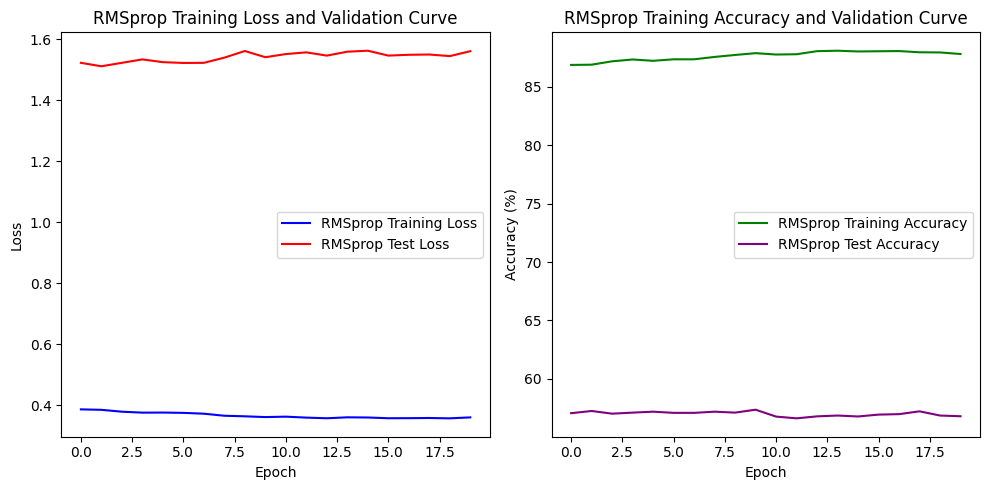

In [66]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(rmsprop_train_loss_values, label='RMSprop Training Loss', color='blue')
plt.plot(rmsprop_test_loss_values, label='RMSprop Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RMSprop Training Loss and Validation Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rmsprop_train_accuracy_values, label='RMSprop Training Accuracy', color='green')
plt.plot(rmsprop_test_accuracy_values, label='RMSprop Test Accuracy', color='purple')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('RMSprop Training Accuracy and Validation Curve')
plt.legend()

plt.tight_layout()
plt.show()

## SGD optimizer Loss and Accuracy


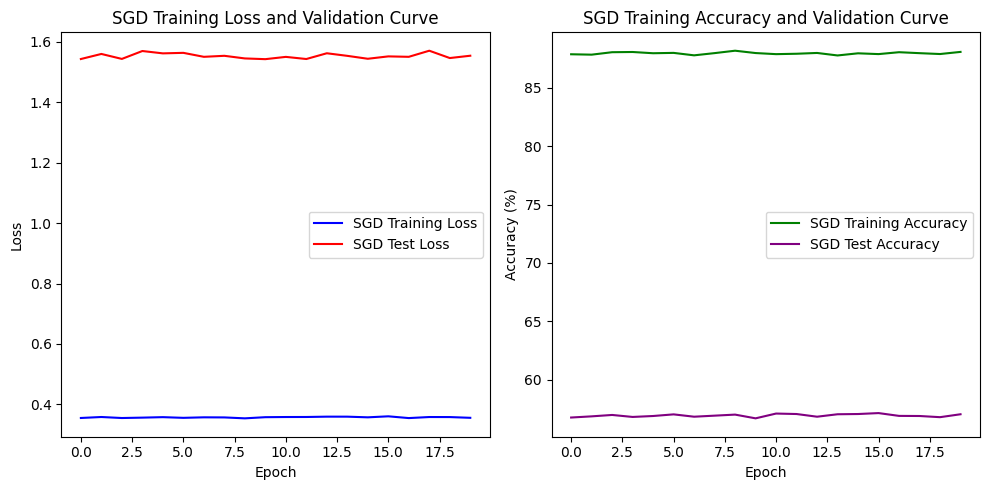

In [67]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sgd_train_loss_values, label='SGD Training Loss', color='blue')
plt.plot(sgd_test_loss_values, label='SGD Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Training Loss and Validation Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sgd_train_accuracy_values, label='SGD Training Accuracy', color='green')
plt.plot(sgd_test_accuracy_values, label='SGD Test Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('SGD Training Accuracy and Validation Curve')
plt.legend()

plt.tight_layout()
plt.show()

## Test model

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


adam_net = Net().to(device)
adam_net.load_state_dict(torch.load('cifar_net_adam.pth'))
adam_net.eval()

rmsprop_net = Net().to(device)
rmsprop_net.load_state_dict(torch.load('cifar_net_rmsprop.pth'))
rmsprop_net.eval()

sgd_net = Net().to(device)
sgd_net.load_state_dict(torch.load('cifar_net_sgd.pth'))
sgd_net.eval()

Files already downloaded and verified


Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)

In [69]:
def get_predictions(model, dataloader):
    all_labels = []
    all_predictions = []
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())
    return all_labels, all_predictions

## Prediction the model

In [70]:
adam_labels, adam_predictions = get_predictions(adam_net, testloader)
rmsprop_labels, rmsprop_predictions = get_predictions(rmsprop_net, testloader)
sgd_labels, sgd_predictions = get_predictions(sgd_net, testloader)

In [71]:
adam_confusion_matrix = confusion_matrix(adam_labels, adam_predictions)
rmsprop_confusion_matrix = confusion_matrix(rmsprop_labels, rmsprop_predictions)
sgd_confusion_matrix = confusion_matrix(sgd_labels, sgd_predictions)

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## confusion matrix

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


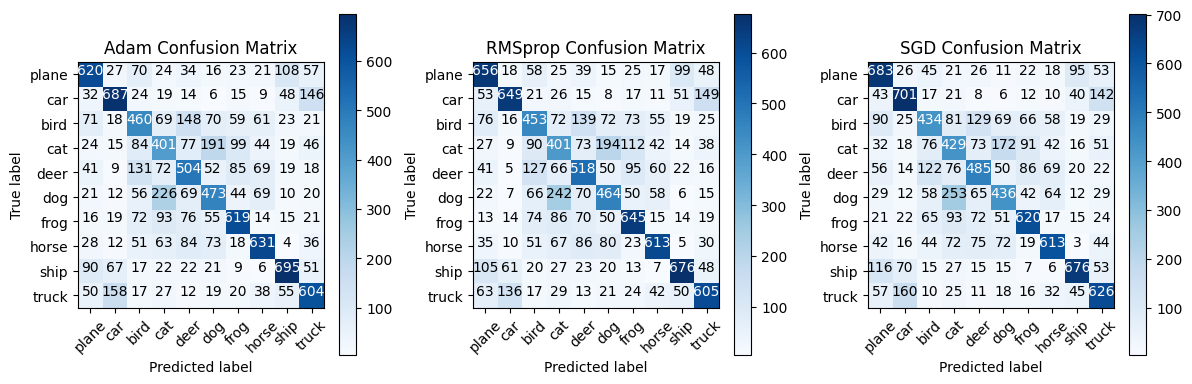

In [73]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plot_confusion_matrix(adam_confusion_matrix, classes=classes, title='Adam Confusion Matrix')

plt.subplot(1, 3, 2)
plot_confusion_matrix(rmsprop_confusion_matrix, classes=classes, title='RMSprop Confusion Matrix')

plt.subplot(1, 3, 3)
plot_confusion_matrix(sgd_confusion_matrix, classes=classes, title='SGD Confusion Matrix')

plt.show()